In [ ]:
!pip install scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 36.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requi

In [ ]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [ ]:
file_path = 'AWT_studentdata_1.csv'
print("Reading data from", file_path)
drive.mount('/content/drive')
data = df = pd.read_csv('/content/drive/My Drive/AWT_studentdata_1.csv')
df = pd.DataFrame(data)
# Randomly sample 10% of the data
#df_sampled = df.sample(frac=0.1, random_state=42)  # Adjust fraction as needed
#df = df.sort_values(by='t', ascending=True)
#df['t'] = df['t'].astype('datetime64[ns]').astype(int)

df['t'] = pd.to_datetime(df['t'])
df['hour'] = df['t'].dt.hour
df['minute'] = df['t'].dt.minute
df['second'] = df['t'].dt.second
df['day_of_week'] = df['t'].dt.dayofweek
df = df.drop(columns=['t'])  # delete the former t

# Encode time as cyclical features
#df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
#df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
#df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
#df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
#df['second_sin'] = np.sin(2 * np.pi * df['second'] / 60)
#df['second_cos'] = np.cos(2 * np.pi * df['second'] / 60)
#df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
#df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

Reading data from AWT_studentdata_1.csv
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ensure that the target column exists
if 'gs_consumption_Wh' not in df.columns:
    raise ValueError("The target column 'gs_consumption_Wh' is not in the dataset.")

In [ ]:
# specify irrelevant columns list
irrelevant_columns = [
    'streamingSessionID',

]
features_df = df.drop(columns= irrelevant_columns + ['gs_consumption_Wh'])
target_df = df['gs_consumption_Wh']

In [ ]:
test_split=round(len(df)*0.20)
df_train=df[:-test_split]
df_test=df[-test_split:]
print(df_train.shape)
print(df_test.shape)

(384868, 36)
(96217, 36)


In [ ]:
feature_scaler = MinMaxScaler(feature_range=(0,1))
target_scaler = MinMaxScaler(feature_range=(0,1))
#df_train_scaled = scaler.fit_transform(df_train)
#df_test_scaled= scaler.transform(df_test)
features_scaled = feature_scaler.fit_transform(features_df)
target_scaled = target_scaler.fit_transform(target_df.values.reshape(-1, 1))
target_scaled

array([[0.27608324],
       [0.27608324],
       [0.27608324],
       ...,
       [0.01040479],
       [0.01040479],
       [0.01040479]])

In [ ]:
# ---------------------------
# Helper function: create sequences
# ---------------------------
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

In [ ]:
# Create time series sequences.
# Define the sequence (window) length. You can adjust this value.
seq_length = 10  # e.g., use previous 10 time steps to predict the next one.
X, Y = create_sequences(features_scaled, target_scaled, seq_length)
print(f"Total sequences created: {X.shape[0]}")

# Split into training and validation (prediction) sets.
# For time series, it is common to use earlier data for training and later data for validation.
split_fraction = 0.8  # 80% for training, 20% for validation
split_index = int(len(X) * split_fraction)

X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]
print(Y_test.shape)

print("Training sequences:", X_train.shape)
print("Validation sequences:", X_test.shape)

Total sequences created: 481075
(96215, 1)
Training sequences: (384860, 10, 34)
Validation sequences: (96215, 10, 34)


In [ ]:
from pickle import FALSE
# 7. Build the LSTM model.
seq_length = 10
n_features = X_train.shape[2]
model = Sequential()
model.add(LSTM(100, return_sequences=FALSE, input_shape=(seq_length, n_features)))
#model.add(LSTM(100, activation='relu', return_sequences=FALSE, input_shape=(seq_length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer)
model.summary()

# Train the model.
epochs = 100
batch_size = 32
print("Training the model...")
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # validate validation loss
    patience=10,         # Stop if validation loss does not improve within 10 epochs
    restore_best_weights=True  # Recover the weights of the best model
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, Y_test), verbose=1, callbacks=[reduce_lr, early_stopping])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 10, 100)             │          54,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,529 (341.91 KB)

 Trainable params: 87,529 (341.91 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/100
6014/6014 ━━━━━━━━━━━━━━━━━━━━ 339s 56ms/step - loss: 0.0067 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 2/100
6014/6014 ━━━━━━━━━━━━━━━━━━━━ 322s 54ms/step - loss: 0.0020 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/100
3564/6014 ━━━━━━━━━━━━━━━━━━━━ 1:59 49ms/step - loss: 0.0019

In [ ]:
print("Predicting on the validation set...")
prediction=model.predict(X_test)
print("\nPrediction Shape-",prediction.shape)

print("Y_test shape:", Y_test.shape)
print("Current prediction shape:", prediction.shape)

Predicting on the validation set...
3007/3007 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step

Prediction Shape- (96213, 1)
Y_test shape: (96213, 1)
Current prediction shape: (96213, 1)


In [ ]:
print(prediction)

[[0.03792499]
 [0.03683421]
 [0.03693129]
 ...
 [0.03039879]
 [0.03047985]
 [0.03073256]]


In [ ]:
y_pred = target_scaler.inverse_transform(prediction)
print(y_pred)
original = target_scaler.inverse_transform(Y_test)

[[415.08173]
 [407.42883]
 [408.10992]
 ...
 [362.2779 ]
 [362.84662]
 [364.61963]]


In [ ]:
# 10. Compute RMSE.
rmse = math.sqrt(mean_squared_error(original, y_pred))
print(f"RMSE on validation set: {rmse:.3f}")

RMSE on validation set: 362.596


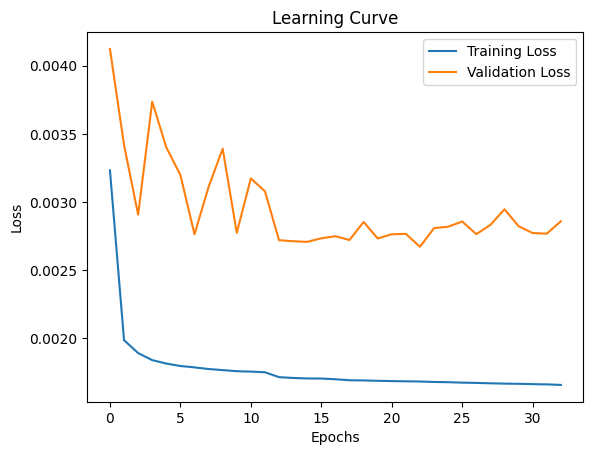

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# 11. Print out a few predictions alongside the actual values.
print("\nSample predictions vs actual values:")
for i in range(min(10, len(y_pred))):
  print(f"Prediction: {y_pred[i][0]:.3f} \t Actual: {original[i][0]:.3f}")


Sample predictions vs actual values:
Prediction: 518.176 	 Actual: 397.000
Prediction: 519.757 	 Actual: 397.000
Prediction: 539.756 	 Actual: 397.000
Prediction: 535.715 	 Actual: 397.000
Prediction: 526.537 	 Actual: 397.000
Prediction: 522.954 	 Actual: 397.000
Prediction: 525.571 	 Actual: 397.000
Prediction: 527.534 	 Actual: 397.000
Prediction: 530.340 	 Actual: 397.000
Prediction: 535.405 	 Actual: 397.000
